<a href="https://colab.research.google.com/github/pen1064/Mask-Faster-R-CNN/blob/main/Faster_R_CNN_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import shutil
import glob
from xml.etree import ElementTree
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image

import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [ ]:
annotations_directory = r'/content/gdrive/MyDrive/mask/annotations'
images_directory = r'/content/gdrive/MyDrive/mask/images'

test_images_directory = r'/content/gdrive/MyDrive/mask/test_images'
test_annotations_directory = r'/content/gdrive/MyDrive/mask/test_annotations'

train_images_directory = r'/content/gdrive/MyDrive/mask/train_images'
train_annotations_directory = r'/content/gdrive/MyDrive/mask/train_annotations'

In [ ]:

if not os.path.isdir(train_annotations_directory): os.mkdir(train_annotations_directory)
if not os.path.isdir(test_annotations_directory): os.mkdir(test_annotations_directory)
if not os.path.isdir(train_images_directory): os.mkdir(train_images_directory)
if not os.path.isdir(test_images_directory): os.mkdir(test_images_directory)

N = len(os.listdir(annotations_directory))

random.seed(2)
idx = random.sample(range(N), int(round(0.2*N)))

test_annotations = np.array(os.listdir(annotations_directory))[idx]
test_images = np.array(os.listdir(images_directory))[idx]


for file in glob.glob(annotations_directory+'/*.xml'):
  ann_filename = file.split('/')[-1]
  img_filename = ann_filename[:-3]+'png'
  if ann_filename in test_annotations:
    shutil.copy(os.path.join(annotations_directory, ann_filename),os.path.join(test_annotations_directory, ann_filename))
    shutil.copy(os.path.join(images_directory, img_filename),os.path.join(test_images_directory, img_filename))
  else:
    shutil.copy(os.path.join(annotations_directory, ann_filename),os.path.join(train_annotations_directory, ann_filename))
    shutil.copy(os.path.join(images_directory, img_filename),os.path.join(train_images_directory, img_filename))

print(len(os.listdir(test_annotations_directory)))
print(len(os.listdir(test_images_directory)))
print(len(os.listdir(train_images_directory)))
print(len(os.listdir(train_annotations_directory)))

171
171
682
682


In [ ]:
TRAIN_DATA = {k:[] for k in ['img_file', 'width', 'height', 'depth', 'name', 'box', 'xmin', 'xmax', 'ymin', 'ymax']}

for file in glob.glob(train_annotations_directory+'/*.xml'):
    tree = ElementTree.parse(file)
    for item in tree.iter():
        if 'size' in item.tag:
            img_dim = [int(i.text) for i in list(item)]
        if 'object' in item.tag:
            d = []
            name = item.find('name').text
            bndbox = item.find('bndbox')
            box = [int(i.text) for i in list(bndbox)]
            TRAIN_DATA['img_file']+= [os.path.join(train_images_directory,file.split('/')[-1][:-3]+'png')]
            TRAIN_DATA['width'] += [img_dim[0]]
            TRAIN_DATA['height'] += [img_dim[1]]
            TRAIN_DATA['depth'] += [img_dim[2]]
            TRAIN_DATA['name'] += [name]
            TRAIN_DATA['box'] += [box]
            TRAIN_DATA['xmin'] += [box[0]]
            TRAIN_DATA['xmax'] += [box[2]]
            TRAIN_DATA['ymin'] += [box[1]]
            TRAIN_DATA['ymax'] += [box[3]]
train_df = pd.DataFrame(TRAIN_DATA)
train_df.head(3)

,img_file,width,height,depth,name,box,xmin,xmax,ymin,ymax
0,/content/gdrive/MyDrive/mask/train_images/maks...,512,366,3,without_mask,"[79, 105, 109, 142]",79,109,105,142
1,/content/gdrive/MyDrive/mask/train_images/maks...,512,366,3,with_mask,"[185, 100, 226, 144]",185,226,100,144
2,/content/gdrive/MyDrive/mask/train_images/maks...,512,366,3,without_mask,"[325, 90, 360, 141]",325,360,90,141


In [ ]:
train_df.name = pd.Categorical(train_df.name)
train_df['name'] = train_df.name.cat.codes
train_df.head(3)

,img_file,width,height,depth,name,box,xmin,xmax,ymin,ymax
0,/content/gdrive/MyDrive/mask/train_images/maks...,512,366,3,2,"[79, 105, 109, 142]",79,109,105,142
1,/content/gdrive/MyDrive/mask/train_images/maks...,512,366,3,1,"[185, 100, 226, 144]",185,226,100,144
2,/content/gdrive/MyDrive/mask/train_images/maks...,512,366,3,2,"[325, 90, 360, 141]",325,360,90,141


In [ ]:
train_df.to_csv('train.csv')

In [ ]:
TEST_DATA = {k:[] for k in ['img_file', 'width', 'height', 'depth', 'name', 'box', 'xmin', 'xmax', 'ymin', 'ymax']}

for file in glob.glob(test_annotations_directory+'/*.xml'):
    tree = ElementTree.parse(file)
    for item in tree.iter():
        if 'size' in item.tag:
            img_dim = [int(i.text) for i in list(item)]
        if 'object' in item.tag:
            d = []
            name = item.find('name').text
            bndbox = item.find('bndbox')
            box = [int(i.text) for i in list(bndbox)]
            TEST_DATA['img_file']+= [os.path.join(test_images_directory,file.split('/')[-1][:-3]+'png')]
            TEST_DATA['width'] += [img_dim[0]]
            TEST_DATA['height'] += [img_dim[1]]
            TEST_DATA['depth'] += [img_dim[2]]
            TEST_DATA['name'] += [name]
            TEST_DATA['box'] += [box]
            TEST_DATA['xmin'] += [box[0]]
            TEST_DATA['xmax'] += [box[2]]
            TEST_DATA['ymin'] += [box[1]]
            TEST_DATA['ymax'] += [box[3]]
test_df = pd.DataFrame(TEST_DATA)
test_df.head(3)

,img_file,width,height,depth,name,box,xmin,xmax,ymin,ymax
0,/content/gdrive/MyDrive/mask/test_images/makss...,400,156,3,with_mask,"[321, 34, 354, 69]",321,354,34,69
1,/content/gdrive/MyDrive/mask/test_images/makss...,400,156,3,with_mask,"[224, 38, 261, 73]",224,261,38,73
2,/content/gdrive/MyDrive/mask/test_images/makss...,400,156,3,with_mask,"[299, 58, 315, 81]",299,315,58,81


In [ ]:
test_df.name = pd.Categorical(test_df.name)
test_df['name'] = test_df.name.cat.codes
test_df.head(3)

,img_file,width,height,depth,name,box,xmin,xmax,ymin,ymax
0,/content/gdrive/MyDrive/mask/test_images/makss...,400,156,3,1,"[321, 34, 354, 69]",321,354,34,69
1,/content/gdrive/MyDrive/mask/test_images/makss...,400,156,3,1,"[224, 38, 261, 73]",224,261,38,73
2,/content/gdrive/MyDrive/mask/test_images/makss...,400,156,3,1,"[299, 58, 315, 81]",299,315,58,81


In [ ]:
class MaskDataset(object):
    def __init__(self, df):
        self.transforms = transforms
        self.df = df
        self.imgs =df['img_file'].unique()

    def __getitem__(self, idx): 
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")
        img = transforms.ToTensor()(img)
  
        target={}
        target['boxes'] = torch.as_tensor(self.df[self.df['img_file'] == self.imgs[idx]]['box'].to_list(), dtype=torch.float32)
        target['labels'] = torch.as_tensor(self.df[self.df['img_file'] == self.imgs[idx]]['name'].to_list(), dtype=torch.int64)

        return img, target

    def __len__(self): 
        return len(self.imgs)

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def get_model_instance_segmentation(num_classes, **kwargs):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    if 'weights' in kwargs:
      model.load_state_dict(torch.load(kwargs['weights']))
    return model

In [ ]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

In [ ]:
for epoch in range(num_epochs):
    start = time.time()
    print(start)
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

1645984225.5727136


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch : 1, Loss : 498.50360107421875, time : 964.1883025169373
1645985189.7611258
epoch : 2, Loss : 360.3045959472656, time : 967.9945075511932
1645986157.7557442
epoch : 3, Loss : 281.201171875, time : 947.1386771202087
1645987104.8945308
epoch : 4, Loss : 233.6462860107422, time : 947.4524910449982
1645988052.347134
epoch : 5, Loss : 200.40579223632812, time : 947.8391728401184
1645989000.1868167
epoch : 6, Loss : 179.8287353515625, time : 948.3118464946747
1645989948.4987724
epoch : 7, Loss : 168.02536010742188, time : 948.6927428245544
1645990897.1916244
epoch : 8, Loss : 157.52468872070312, time : 948.6989896297455
1645991845.8916273
epoch : 9, Loss : 148.17457580566406, time : 949.0711894035339
1645992794.9635546
epoch : 10, Loss : 137.47486877441406, time : 949.5049312114716


In [ ]:
torch.save(model.state_dict(),r'/content/gdrive/MyDrive/mask/model_epoch10.pt')

In [ ]:
model = get_model_instance_segmentation(4, weights=r'/content/gdrive/MyDrive/mask/model_epoch10.pt')

In [ ]:
def make_prediction(model, img, threshold):
  model.eval()
  preds = model(img)
  for id in range(len(preds)):
    ind_list = [idx for idx, score in enumerate(preds[id]['scores']) if score > threshold]
    preds[id]['boxes'] = preds[id]['boxes'][ind_list]
    preds[id]['labels'] = preds[id]['labels'][ind_list]
    preds[id]['scores'] = preds[id]['scores'][ind_list]
  return preds

In [ ]:
with torch.no_grad():
  for imgs, annotations in test_data_loader:
    imgs = list(img.to(device) for img in imgs)
    pred = make_prediction(model, imgs, 0.5)

2
target: tensor([1, 1])


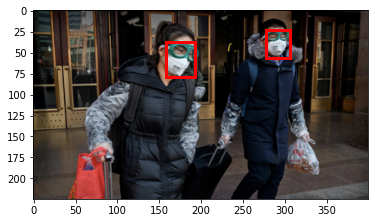

In [ ]:
ind = 1
img_cpu = imgs[ind].cpu().permute(1,2,0)
print(len(pred[ind]['boxes']))
fig, ax = plt.subplots()
ax.imshow(img_cpu)

print("target:", annotations[ind]['labels'])
for i, b in enumerate(pred[ind]['boxes']):
  b = b.cpu()
  if pred[ind]['labels'][i] == 1:
    rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor='r', facecolor='none')
  elif pre[ind]['labels'][i] == 2:
    rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor='g', facecolor='none')
  else:
    rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor='o', facecolor='none')
  ax.add_patch(rect)
plt.show()

torch.Size([1, 3, 2048, 1536])


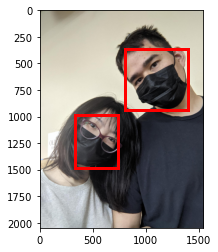

In [ ]:
img1 = Image.open(r'/content/gdrive/MyDrive/mask/test_mask.jpg').convert("RGB")                  
img = data_transform(img1)
img = img.unsqueeze_(0)
print(img.shape)
img = img.to(device)
with torch.no_grad():
  p = make_prediction(model, img, 0.5)

fig, ax = plt.subplots()
ax.imshow(img1)

for i, b in enumerate(p[0]['boxes']):
  b = b.cpu()
  if p[0]['labels'][i] == 1:
    rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor='r', facecolor='none')
  elif p[0]['labels'][i] == 2:
    rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor='g', facecolor='none')
  else:
    rect = patches.Rectangle((b[0], b[1]), (b[2]-b[0]), (b[3]-b[1]), linewidth=3, edgecolor='o', facecolor='none')
  ax.add_patch(rect)
plt.show()